# Smart Meters in London: Data Analysis and ML model (Part 3/3)

This jupyter notebook wants to analyse the data coming from the energy consumption of different users, to see how a forecast algorithm can be developed, or clustering models can be done. 

The structure of this notebook is as follows: 

Analysis of different household, according to different types of tariffs, to see whether there are different patterns. 


In [1]:
# Importing libraries required for the analysis 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import datetime as dt
from sqlalchemy import create_engine 
import os
import sklearn 

# Importing libraries required for T-S analysis
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA
from pandas.plotting import lag_plot
import itertools

# Seting style for matplotlib
plt.style.use('ggplot')

In [72]:
# Reading the current working directoy to see where are we writing the code. 
os.getcwd()

'/home/ingrid/Documents/DA_Ironhack/Week8/Final_Project/your-project/2.JupyterNotebooks'

In [73]:
# Seeing all the files we have in clean_data folder 
os.listdir('../0.Data/clean_data')

['halfhourly_block12_cleaned.csv',
 'MAC000291_cleaned_consumption.csv',
 'info_househoulds_cleaned.csv',
 'weather_hourly_cleaned.csv']

In [74]:
users_info = pd.read_csv('../0.Data/clean_data/info_househoulds_cleaned.csv', index_col=0)

In [75]:
users_info.head()

,LCLid,stdorToU,Acorn,Acorn_grouped,file
0,MAC005492,ToU,ACORN-,ACORN-,block_0
1,MAC001074,ToU,ACORN-,ACORN-,block_0
2,MAC000002,Std,ACORN-A,Affluent,block_0
3,MAC003613,Std,ACORN-A,Affluent,block_0
4,MAC003597,Std,ACORN-A,Affluent,block_0


In [76]:
users_info.columns = ['LCLid', 'tariff', 'acorn_class', 'acorn_group', 'file']

In [77]:
users_info['tariff'].value_counts()

Std    4443
ToU    1123
Name: tariff, dtype: int64

Text(0.5, 0, 'Type of tariff')

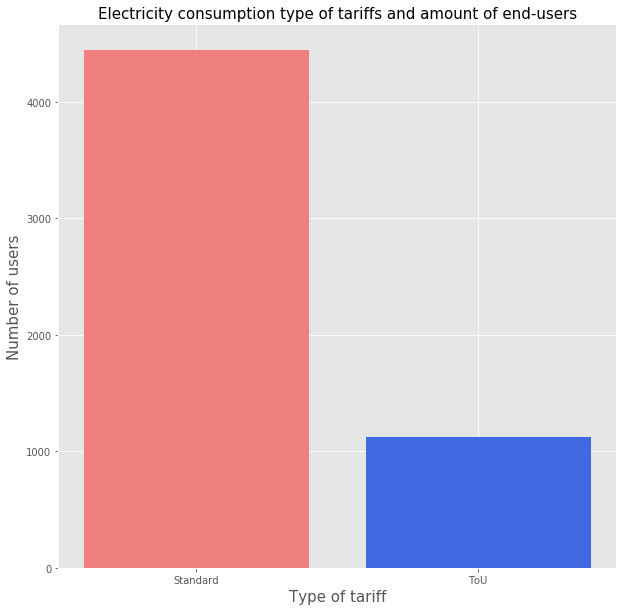

In [78]:
plt.figure(figsize=(10,10))
plt.bar(x=['Standard','ToU'], height=users_info['tariff'].value_counts(), color=['lightcoral', 'royalblue'])
plt.title("Electricity consumption type of tariffs and amount of end-users", fontsize=15)
plt.ylabel("Number of users", fontsize=15)
plt.xlabel('Type of tariff', fontsize=15)

As we can see from the graph above, there are two different types of tariff that the user can contract: **Standard** and **ToU**. Also we can see that there is a huge tendency on the amount of users to have a Standard contract instead of a ToU contract. 


We will choose two end-users with a Standard Tariff contracted and later on we will choose two end-users with a ToU tariff, to see whether there are significant differences in the model. 

In [79]:
users_info[(users_info['tariff']=='ToU') & (users_info['file']=='block_12')].head()

,LCLid,tariff,acorn_class,acorn_group,file
600,MAC005106,ToU,ACORN-D,Affluent,block_12
604,MAC005179,ToU,ACORN-D,Affluent,block_12
610,MAC001495,ToU,ACORN-D,Affluent,block_12
611,MAC002622,ToU,ACORN-D,Affluent,block_12
613,MAC002645,ToU,ACORN-D,Affluent,block_12


In [80]:
users_info[(users_info['tariff']=='Std') & (users_info['file']=='block_12')].head()

,LCLid,tariff,acorn_class,acorn_group,file
601,MAC004340,Std,ACORN-D,Affluent,block_12
602,MAC002137,Std,ACORN-D,Affluent,block_12
603,MAC001800,Std,ACORN-D,Affluent,block_12
605,MAC005182,Std,ACORN-D,Affluent,block_12
606,MAC004280,Std,ACORN-D,Affluent,block_12


We will use the data coming from two users with ToU Tariff and two with Std Tariff that they are also in block_12 since it is the block that we have cleaned before. We will import block_12 to analyse these data. 

`ToU users`: MAC001495 and MAC002645

`Standard users`: MAC001800 and MAC004280 and MAC000291

In [91]:
half_hourly_df = pd.read_csv('../0.Data/clean_data/halfhourly_block12_cleaned.csv', index_col=0)

In [92]:
half_hourly_df.tail()

,LCLid,DateTime,kWh/hh
1591182,MAC005399,2014-02-27 22:00:00,0.121
1591183,MAC005399,2014-02-27 22:30:00,0.033
1591184,MAC005399,2014-02-27 23:00:00,0.066
1591185,MAC005399,2014-02-27 23:30:00,0.082
1591186,MAC005399,2014-02-28 00:00:00,0.140


## Standard Users. MAC000291

In [150]:
MAC000291_df = half_hourly_df[half_hourly_df['LCLid']=='MAC000291']

In [151]:
MAC000291_df.head()

,LCLid,DateTime,kWh/hh
0,MAC000291,2012-03-02 09:30:00,1.158
1,MAC000291,2012-03-02 10:00:00,1.499
2,MAC000291,2012-03-02 10:30:00,1.433
3,MAC000291,2012-03-02 11:00:00,0.510
4,MAC000291,2012-03-02 11:30:00,0.455


In [152]:
MAC000291_df.dtypes

LCLid        object
DateTime     object
kWh/hh      float64
dtype: object

In [153]:
def df_arrange(df, id_column, dt_column):
    # Changing the type of DateTime column into DateTime 
    
    df[dt_column] = pd.to_datetime(df[dt_column])

    # Setting DateTime as index of the dataframe 
    df.index = df[dt_column].sort_index()

    # Droping DateTime and LCLid columns 
    df.drop([id_column, dt_column], axis = 1, inplace = True )
    
    # Changing names of the columns
    df.columns= ['kWh']
    
    # Resample df into hourly data 
    return df.resample('H').sum()

In [154]:
MAC000291_df_h = df_arrange(MAC000291_df, 'LCLid', 'DateTime' )

/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [155]:
MAC000291_df_h.head()

,kWh
DateTime,
2012-03-02 09:00:00,1.158
2012-03-02 10:00:00,2.932
2012-03-02 11:00:00,0.965
2012-03-02 12:00:00,0.734
2012-03-02 13:00:00,0.694


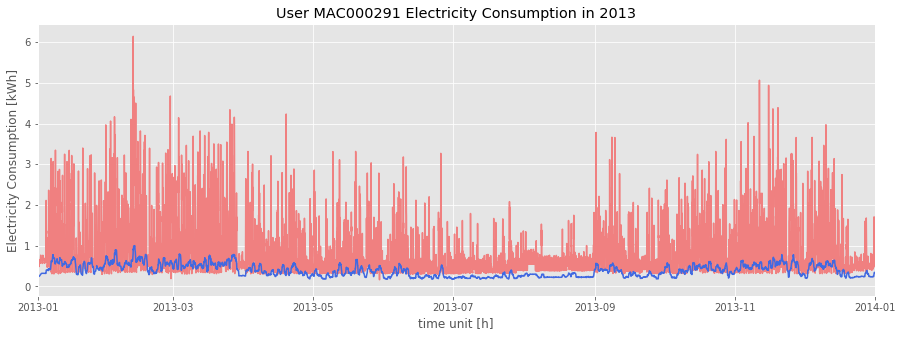

In [160]:
plt.figure(figsize=(15,5))
plt.plot(MAC000291_df_h['2013'], color='lightcoral')
plt.plot(moving_avg_24h, color='royalblue' )
plt.title('User MAC000291 Electricity Consumption in 2013')
plt.xlabel('time unit [h]', fontsize=12)
plt.ylabel('Electricity Consumption [kWh]', fontsize=12)

plt.xlim('2013-01-01 00:00:00', '2014-01-01 00:00:00')
plt.show()

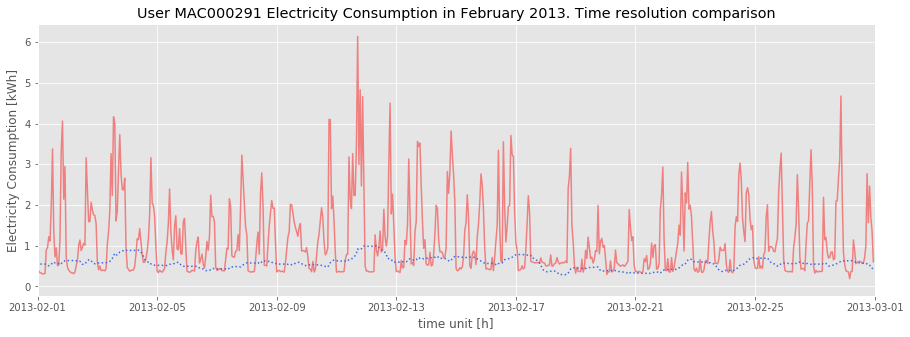

In [157]:
plt.figure(figsize=(15,5))
plt.plot(MAC000291_df_h['2013-02'], color='lightcoral')
plt.plot(moving_avg_24h, color='royalblue', linestyle=':' )
plt.title('User MAC000291 Electricity Consumption in February 2013. Time resolution comparison')
plt.xlabel('time unit [h]', fontsize=12)
plt.ylabel('Electricity Consumption [kWh]', fontsize=12)

plt.xlim('2013-02-01 00:00:00', '2013-03-01 00:00:00')
plt.show()

In [161]:
moving_avg_1h = MAC000291_df_h.rolling(window=1).mean()
moving_avg_2h = MAC000291_df_h.rolling(window=2).mean()
moving_avg_12h = MAC000291_df_h.rolling(window=12).mean()
moving_avg_24h = MAC000291_df_h.rolling(window=24).mean()

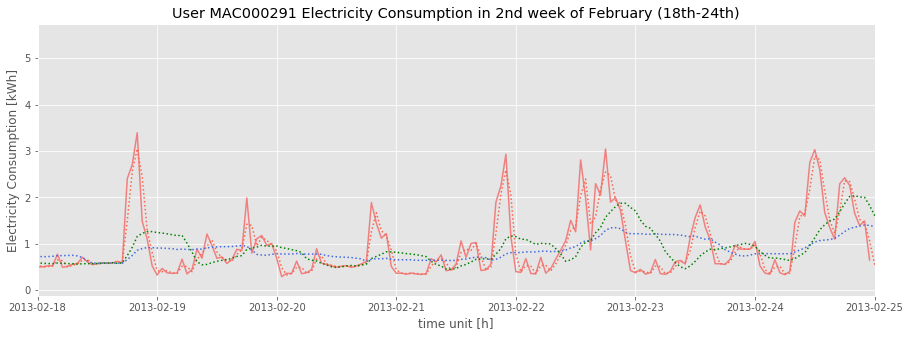

In [164]:
plt.figure(figsize=(15,5))
plt.plot(MAC000291_df_h['2013-02-18':'2013-02-24'], color='lightcoral')
#plt.plot(moving_avg_1h, color='black', linestyle=':' )
plt.plot(moving_avg_24h, color='royalblue', linestyle=':' )
plt.plot(moving_avg_2h, color='tomato', linestyle=':' )
plt.plot(moving_avg_12h, color='green', linestyle=':' )
plt.title('User MAC000291 Electricity Consumption in 2nd week of February (18th-24th)')
plt.xlabel('time unit [h]', fontsize=12)
plt.ylabel('Electricity Consumption [kWh]', fontsize=12)

plt.xlim('2013-02-18 00:00:00', '2013-02-25 00:00:00')
plt.show()

## Standard User. MAC004280
 

In [166]:
MAC004280_df = half_hourly_df[half_hourly_df['LCLid']=='MAC004280']
MAC004280_df_h = df_arrange(MAC004280_df , 'LCLid', 'DateTime' )

/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


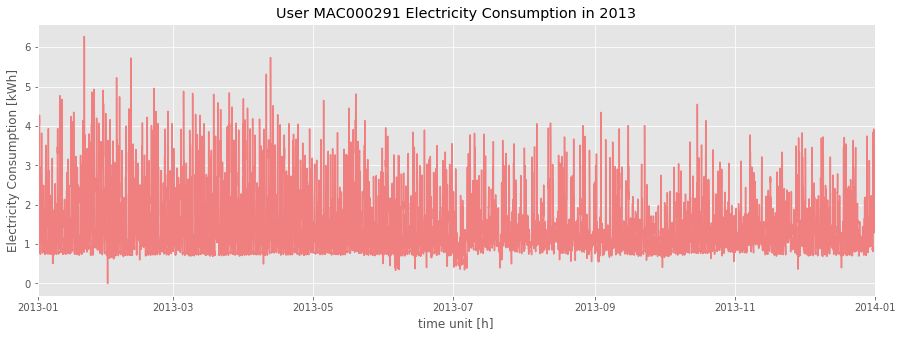

In [167]:
plt.figure(figsize=(15,5))
plt.plot(MAC004280_df_h['2013'], color='lightcoral')
#plt.plot(moving_avg_24h, color='royalblue' )
plt.title('User MAC004280 Electricity Consumption in 2013')
plt.xlabel('time unit [h]', fontsize=12)
plt.ylabel('Electricity Consumption [kWh]', fontsize=12)

plt.xlim('2013-01-01 00:00:00', '2014-01-01 00:00:00')
plt.show()

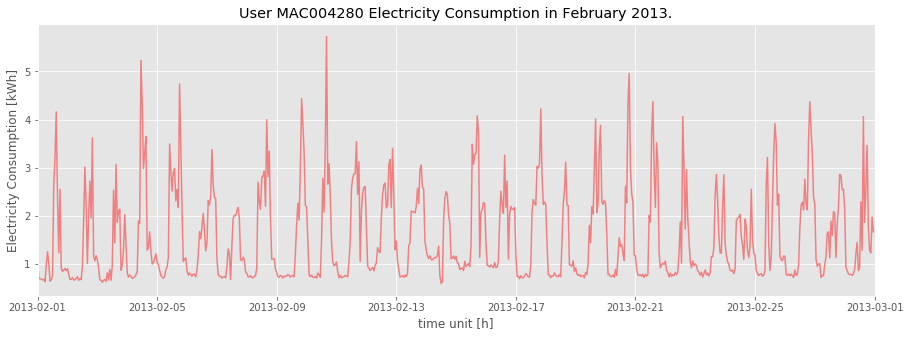

In [170]:
plt.figure(figsize=(15,5))
plt.plot(MAC004280_df_h['2013-02'], color='lightcoral')
#plt.plot(moving_avg_24h, color='royalblue', linestyle=':' )
plt.title('User MAC004280 Electricity Consumption in February 2013.')
plt.xlabel('time unit [h]', fontsize=12)
plt.ylabel('Electricity Consumption [kWh]', fontsize=12)

plt.xlim('2013-02-01 00:00:00', '2013-03-01 00:00:00')
plt.show()

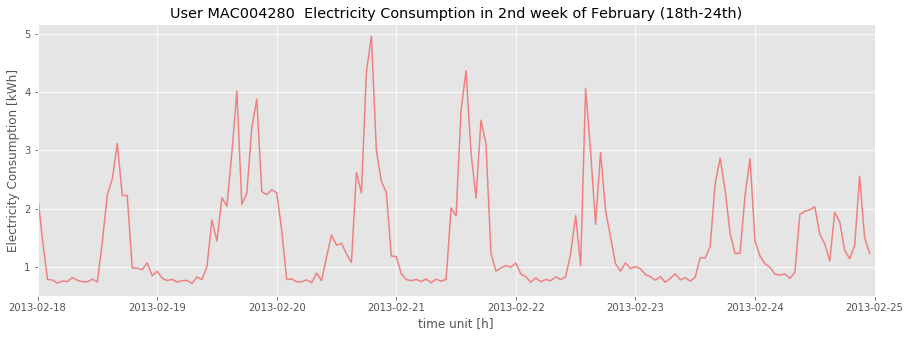

In [190]:
plt.figure(figsize=(15,5))
plt.plot(MAC004280_df_h['2013-02-18':'2013-02-24'], color='lightcoral')
#plt.plot(moving_avg_1h, color='black', linestyle=':' )
# plt.plot(moving_avg_24h, color='royalblue', linestyle=':' )
# plt.plot(moving_avg_2h, color='tomato', linestyle=':' )
# plt.plot(moving_avg_12h, color='green', linestyle=':' )
plt.title('User MAC004280  Electricity Consumption in 2nd week of February (18th-24th)')
plt.xlabel('time unit [h]', fontsize=12)
plt.ylabel('Electricity Consumption [kWh]', fontsize=12)

plt.xlim('2013-02-18 00:00:00', '2013-02-25 00:00:00')
plt.show()

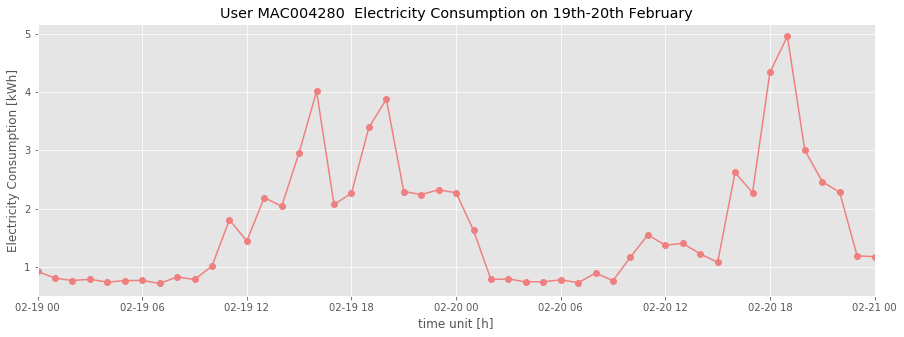

In [200]:
plt.figure(figsize=(15,5))
plt.plot(MAC004280_df_h['2013-02-19':'2013-02-21'], color='lightcoral', marker='o')
#plt.plot(moving_avg_1h, color='black', linestyle=':' )
# plt.plot(moving_avg_24h, color='royalblue', linestyle=':' )
#plt.plot(moving_avg_2h, color='tomato', linestyle=':' )
# plt.plot(moving_avg_12h, color='green', linestyle=':' )
plt.title('User MAC004280  Electricity Consumption on 19th-20th February')
plt.xlabel('time unit [h]', fontsize=12)
plt.ylabel('Electricity Consumption [kWh]', fontsize=12)

plt.xlim('2013-02-19 00:00:00', '2013-02-21 00:00:00')
plt.show()

## ToU Tariff. MAC001495

In [171]:
MAC001495_df = half_hourly_df[half_hourly_df['LCLid']=='MAC001495']
MAC001495_df_h = df_arrange(MAC001495_df , 'LCLid', 'DateTime' )

/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


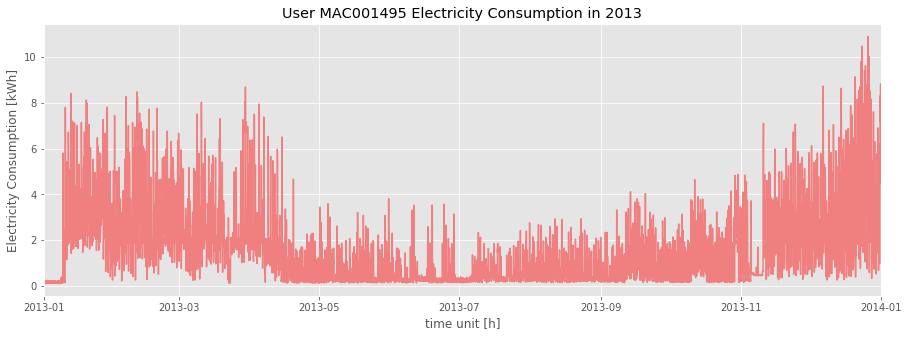

In [172]:
plt.figure(figsize=(15,5))
plt.plot(MAC001495_df_h['2013'], color='lightcoral')
#plt.plot(moving_avg_24h, color='royalblue' )
plt.title('User MAC001495 Electricity Consumption in 2013')
plt.xlabel('time unit [h]', fontsize=12)
plt.ylabel('Electricity Consumption [kWh]', fontsize=12)

plt.xlim('2013-01-01 00:00:00', '2014-01-01 00:00:00')
plt.show()

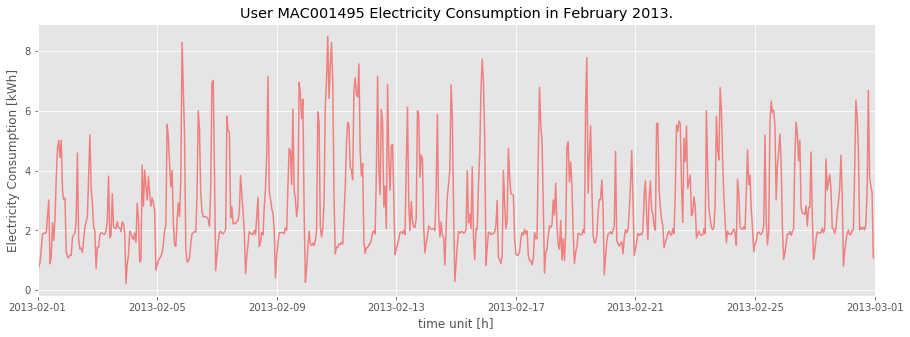

In [174]:
plt.figure(figsize=(15,5))
plt.plot(MAC001495_df_h['2013-02'], color='lightcoral')
#plt.plot(moving_avg_24h, color='royalblue', linestyle=':' )
plt.title('User MAC001495 Electricity Consumption in February 2013.')
plt.xlabel('time unit [h]', fontsize=12)
plt.ylabel('Electricity Consumption [kWh]', fontsize=12)

plt.xlim('2013-02-01 00:00:00', '2013-03-01 00:00:00')
plt.show()

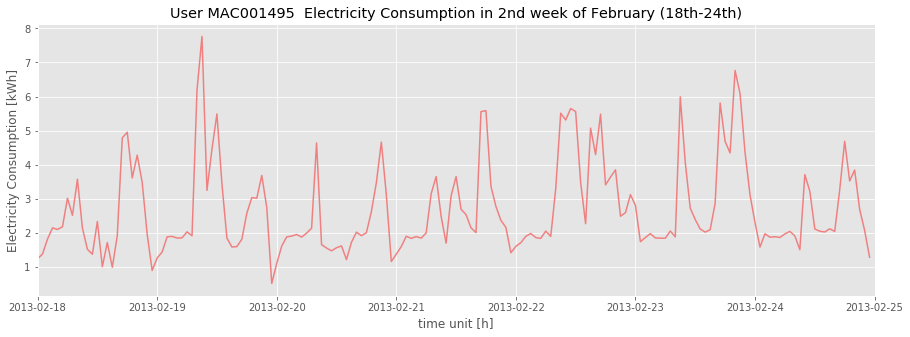

In [175]:
plt.figure(figsize=(15,5))
plt.plot(MAC001495_df_h['2013-02-18':'2013-02-24'], color='lightcoral')
#plt.plot(moving_avg_1h, color='black', linestyle=':' )
# plt.plot(moving_avg_24h, color='royalblue', linestyle=':' )
# plt.plot(moving_avg_2h, color='tomato', linestyle=':' )
# plt.plot(moving_avg_12h, color='green', linestyle=':' )
plt.title('User MAC001495  Electricity Consumption in 2nd week of February (18th-24th)')
plt.xlabel('time unit [h]', fontsize=12)
plt.ylabel('Electricity Consumption [kWh]', fontsize=12)

plt.xlim('2013-02-18 00:00:00', '2013-02-25 00:00:00')
plt.show()

## ToU Tariff. MAC002645

In [176]:
MAC002645_df = half_hourly_df[half_hourly_df['LCLid']=='MAC002645']
MAC002645_df_h = df_arrange(MAC002645_df , 'LCLid', 'DateTime' )

/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


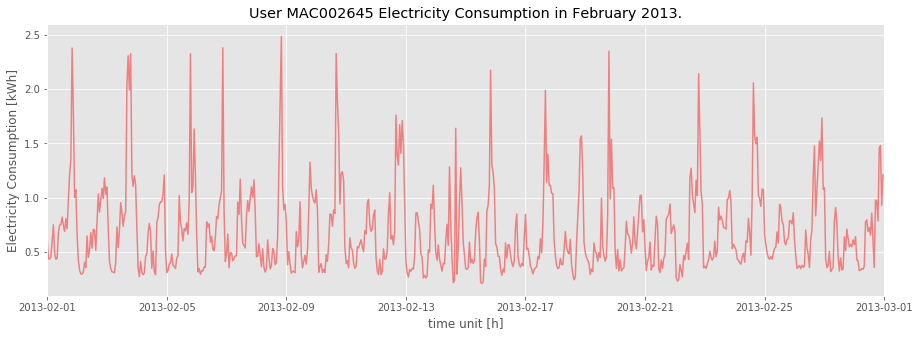

In [177]:
plt.figure(figsize=(15,5))
plt.plot(MAC002645_df_h['2013-02'], color='lightcoral')
#plt.plot(moving_avg_24h, color='royalblue', linestyle=':' )
plt.title('User MAC002645 Electricity Consumption in February 2013.')
plt.xlabel('time unit [h]', fontsize=12)
plt.ylabel('Electricity Consumption [kWh]', fontsize=12)

plt.xlim('2013-02-01 00:00:00', '2013-03-01 00:00:00')
plt.show()

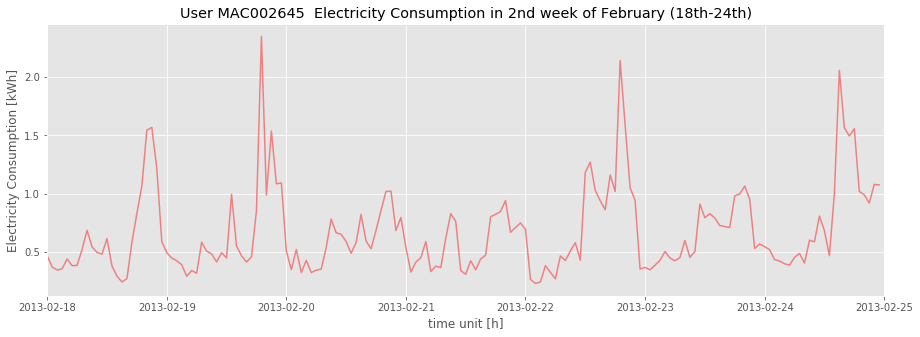

In [178]:
plt.figure(figsize=(15,5))
plt.plot(MAC002645_df_h['2013-02-18':'2013-02-24'], color='lightcoral')
#plt.plot(moving_avg_1h, color='black', linestyle=':' )
# plt.plot(moving_avg_24h, color='royalblue', linestyle=':' )
# plt.plot(moving_avg_2h, color='tomato', linestyle=':' )
# plt.plot(moving_avg_12h, color='green', linestyle=':' )
plt.title('User MAC002645  Electricity Consumption in 2nd week of February (18th-24th)')
plt.xlabel('time unit [h]', fontsize=12)
plt.ylabel('Electricity Consumption [kWh]', fontsize=12)

plt.xlim('2013-02-18 00:00:00', '2013-02-25 00:00:00')
plt.show()